In [ ]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: center;">

# Optimize Object Detection with EfficientDet and TensorRT 8

## Overview

This notebook will show how to optimize a pre-trained TensorFlow EfficientDet model checkpoint using TensorRT 8.0.1. NVIDIA TensorRT is a platform for high-performance deep learning inference. It includes a deep learning inference optimizer and runtime that delivers low latency and high-throughput for deep learning inference applications. After optimizing the pre-trained TF EfficientDet-D0 model for object detection with NVIDIA TensorRT, inference throughput increased by up to 2x to 3x over native Tensorflow depending on the batch size and precision used for TensorRT conversion.

One of the most important problems in computer vision is object detection, where objects of interest like cars, people, obstacles, etc., need to be detected. Since the inception of deep learning algorithms, there has been a lot of research in developing model architectures that can help detect and classify such objects in photos or videos. [EfficientDet](https://arxiv.org/abs/1911.09070) is state of the art object detector which is efficient and accurate while requiring less computational resources. Such a network with accuracy, low compute, and memory requirement is perfect in robotics and driverless car systems.  

## Model architecture


Recently, the Google Brain team released their own ConvNet model called **[EfficientNet](https://arxiv.org/abs/1905.11946)**. EfficientNet forms the backbone of the **EfficientDet**. The model seeks to optimize downstream performance (eg. Object detection) given free range over depth, width, and resolution while staying within the constraints of target memory and target FLOPs. The new model architecture is discovered through neural architecture search where it optimizes for accuracy, given a certain number of FLOPS, and results in the creation of a baseline ConvNet called EfficientNet-D0. This baseline model is scaled up using compound scaling, which jointly scales up all dimensions to create a family of EfficientDet models from baseline EfficientDet-D0 through EfficientDet-D7.

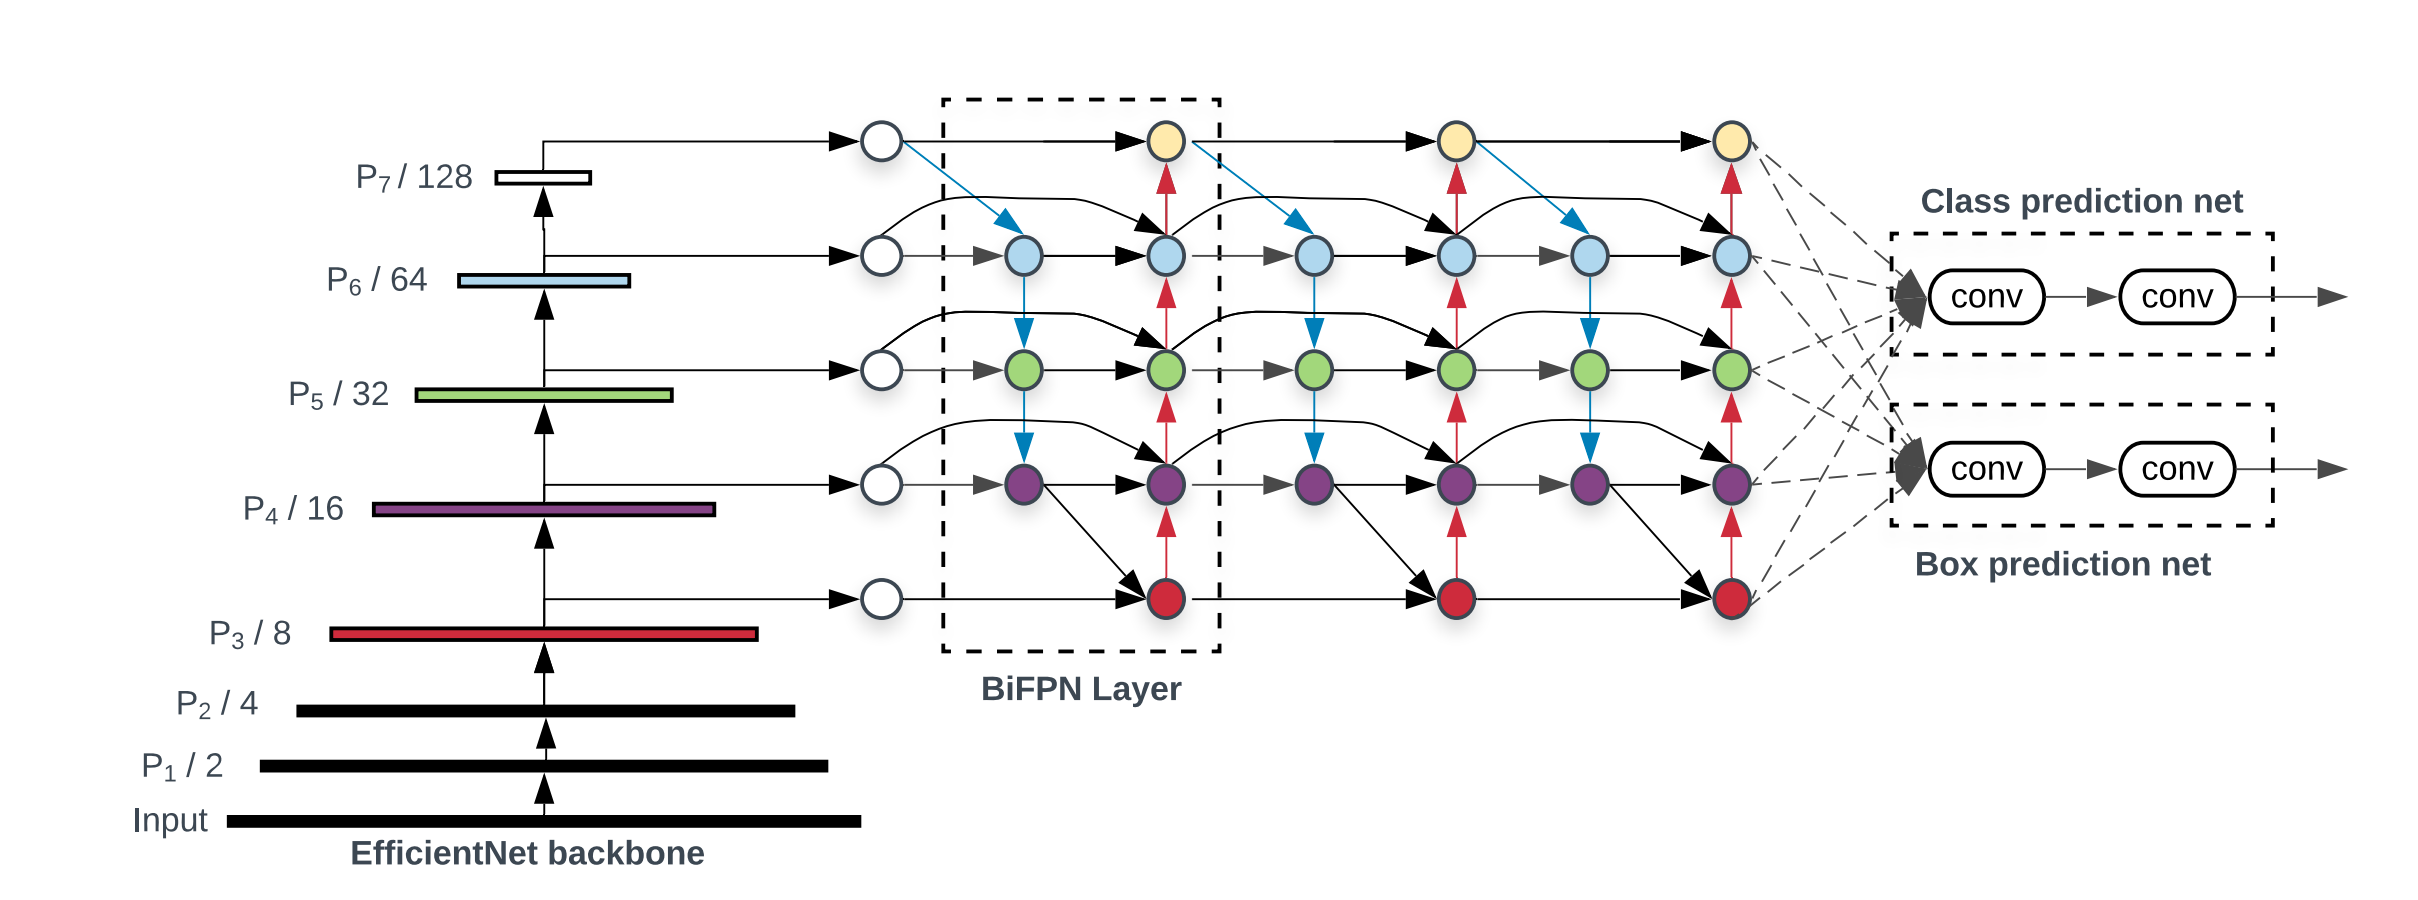

[EfficientDet](https://arxiv.org/abs/1911.09070) architecture – It employs [EfficientNet](https://arxiv.org/abs/1905.11946) as the backbone network, BiFPN as the feature network, and shared class/box prediction network

## TensorRT model conversion pipeline

TensorRT provides a lot of options for model optimization like reduced precision, batching, layer fusion, etc. In particular, for EfficientDet model, additional optimizations are performed in addition to the ones mentioned previously:
* Fusion of Convolution+Swish layers (used throughout the EfficientNet backbone)
* Improved INT8 Global Average Pooling (used in the SE blocks of EfficientNet backbone)

To run a model with TensorRT, we'll follow these steps: 
* Download and save pre-trained TensorFlow model checkpoint in saved model format
* Export the checkpoint an ONNX model
* Build TensorRT engine from the ONNX model and serialize to TensorRT plan file

The final TensorRT engine of EfficientDet can then be launched for inference. Note that TensorRT engine is being runtime optimized before serialization. TensorRT tries a vast set of options to find the strategy that performs best on user’s GPU (depends on the type of underlying GPU) - so it takes a few minutes. After the TensorRT plan file is created, it can be reused.

## Requirements

* Nvidia GPU (Check TensorRT 8 for GPU requirements)
* Nvidia driver 465 with CUDA toolkit 
* TensorRT >= 8.0.1 as per [TensorRT installation](https://docs.nvidia.com/deeplearning/tensorrt/install-guide/index.html) guide
* TensorFlow >= 2.4.0

## Setup

Before running this notebook, please check whether NVIDIA driver, CUDA, TensorRT are installed using the following commands:

In [ ]:
# NVIDIA driver and CUDA version
!nvidia-smi

In [ ]:
# TensorRT version
!python3 -c 'import tensorrt; print("TensorRT version: {}".format(tensorrt.__version__))'

You will need to make sure the Python bindings for TensorRT are also installed correctly, these are available by installing the `python3-libnvinfer` and `python3-libnvinfer-dev` packages on your TensorRT download.

In [ ]:
!dpkg -l | grep TensorRT

# Check 'Python 3 bindings for TensorRT'
# Check 'Python 3 development package for TensorRT'

## Install dependencies for EfficientDet

### 1. Install requirements and dependencies

In [ ]:
# EfficientDet sample is present at this location
!ls -ltr $TRT_OSSPATH/samples/python/efficientdet

In [ ]:
# Install the dependencies
!pip3 install -r $TRT_OSSPATH/samples/python/efficientdet/requirements.txt

### 2. Clone [AutoML github repository](https://github.com/google/automl) 

In [ ]:
!git clone https://github.com/google/automl

### 3. Install requirements for AutoML

In [ ]:
!pip3 install matplotlib>=3.0.3 PyYAML>=5.1 tensorflow-model-optimization>=0.5

The full list of requirements for AutoML is present at `automl/efficientdet/requirements.txt`, but we only need the above for this example.

### 4. Install onnx_graphsurgeon 

You will also need the latest onnx_graphsurgeon python module. If not already installed by TensorRT, you can install it manually by running:

In [ ]:
!pip3 install 'git+https://github.com/NVIDIA/TensorRT#subdirectory=tools/onnx-graphsurgeon'

# Model conversion

## 1. TensorFlow Saved Model

The first step in TensorRT pipeline for EfficientDet is downloading pre-trained TensorFlow checkpoint and converting it into TensorFlow saved model as follows:  

In [ ]:
![ ! -d "tf_checkpoint" ] && mkdir tf_checkpoint
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco2/efficientdet-d0.tar.gz -P tf_checkpoint
!tar -xvf tf_checkpoint/efficientdet-d0.tar.gz -C tf_checkpoint

In [ ]:
!ls tf_checkpoint/efficientdet-d0/

## 2. Export a TensorFlow saved model

The extracted TensorFlow checkpoint now be converted into saved model format using the automl/efficientdet/model_inspect.py script:
```
* --runmode is passed as saved_model
* --model_name supports any one of the model from efficientdet-d0 to efficientdet-d7x
* --ckpt_path /path/to/tf_checkpoint
* --saved_model_dir /path/to/tf_model with protobuf graph and other related files inside.
```

In [ ]:
# Create a directory to store TensorFlow saved model 
![ ! -d "tf_model" ] && mkdir tf_model

# Export TF model
!python3 ./automl/efficientdet/model_inspect.py \
    --runmode saved_model \
    --model_name efficientdet-d0 \
    --ckpt_path ./tf_checkpoint/efficientdet-d0/ \
    --saved_model_dir ./tf_model

In [ ]:
!ls tf_model/

## 3. Create ONNX Graph

To generate an ONNX model file, first find the input shape that corresponds to the model you're converting:

| **Model**        | **Input Shape** |
| -----------------|-----------------|
| EfficientDet D0  | N,512,512,3     |
| EfficientDet D1  | N,640,640,3     |
| EfficientDet D2  | N,768,768,3     |
| EfficientDet D3  | N,896,896,3     |
| EfficientDet D4  | N,1024,1024,3   |
| EfficientDet D5  | N,1280,1280,3   |
| EfficientDet D6  | N,1280,1280,3   |
| EfficientDet D7  | N,1536,1536,3   |
| EfficientDet D7x | N,1536,1536,3   |


Where **N** is the batch size you would like to run inference at, such as `8,512,512,3` for a batch size of 8.

The conversion process supports both NHWC and NCHW input formats, so if your input source is an `NCHW` data format, you can use the corresponding input shape, i.e. `1,512,512,3` -> `1,3,512,512`.

To create the ONNX graph, execute efficientdet/create_onnx.py script which takes the following arguments:
```
* --saved_model /path/to/tf_model 
* --onnx /path/to/onnx.model
* --input_shape One of the input shapes corresponding to the model mentioned previously
```

In [ ]:
# Create directory for onnx_model
![ ! -d "onnx_model" ] && mkdir onnx_model

# Export TF to ONNX
!python3 $TRT_OSSPATH/samples/python/efficientdet/create_onnx.py \
    --saved_model ./tf_model/ \
    --onnx ./onnx_model/model.onnx \
    --input_shape '1,512,512,3'

This will create the file `model.onnx` which is ready to be converted to TensorRT. 

You can visualize the resulting file with a tool such as [Netron](https://netron.app/).

The script has a few additional arguments:

* `--nms_threshold` allows overriding the NMS score threshold value. The runtime latency of the EfficientNMS plugin is sensitive to the score threshold used, so it's a good practice to set this value as high as possible, while still fulfilling your application requirements, to reduce latency as much as possible.
* `--legacy_plugins` allows falling back to older plugins on systems where a version lower than TensorRT 8.0.1 is installed. This will result in substantially slower inference times however.


## 4. Build TensorRT engine

Final step is to convert the exported ONNX model into TensorRT using the efficientdet/build_engine.py script
```
* --onnx /path/to/model.onnx
* --engine /path/to/trt_output
* --precision (fp32,fp16,int8)
```

In [ ]:
# Create directory for exported TensorRT engine
![ ! -d "trt_engine" ] && mkdir trt_engine

# Build engine with FP32 precision
!python3 $TRT_OSSPATH/samples/python/efficientdet/build_engine.py \
    --onnx ./onnx_model/model.onnx \
    --engine ./trt_engine/engine.trt \
    --precision fp32

## To build TensorRT engine with INT8 precision run the following after setting path to 'calib_input' and 'calib_cache':
# python $TRT_OSSPATH/samples/python/efficientdet/build_engine.py \
#     --onnx ./onnx_model/model.onnx \
#     --engine ./trt_engine/engine.trt \
#     --precision int8 \
#     --calib_input /path/to/calibration/images \
#     --calib_cache /path/to/calibration.cache

# Where --calib_input points to a directory with several thousands of images. 
# For example, this could be a subset of the training or validation datasets that were used for the model.
# It is important that this data represents the runtime data distribution relatively well, therefore,
# the more images that are used for calibration, the better accuracy that will be achieved in INT8 precision. 
# For models trained for the COCO dataset, we have found that 5,000 images gives a good result.

# The --calib_cache controls where the calibration cache file will be written to.
# This is useful to keep a cached copy of the calibration results. 
# Next time you need to build the engine for the same network, if this file exists, 
# it will skip the calibration step and use the cached values instead.

# Run python build_engine.py --help for additional calibration options.

The file `engine.trt` will be created, which can now be used to infer with TensorRT.
For best results, make sure no other processes are using the GPU during engine build, as it may affect the optimal tactic selection process.

In [ ]:
!ls trt_engine/

# Benchmarking TensorRT Engine

Optionally, you can obtain execution timing information for the built engine by using the trtexec utility, as:

`NOTE:` After a succesful TensorRT OSS build, the `trtexec` binary should have been created in the `out/` directory.

In [ ]:
!/workspace/TensorRT/build/out/trtexec \
    --loadEngine=trt_engine/engine.trt \
    --useCudaGraph --noDataTransfers \
    --iterations=100 --avgRuns=100

The step above should generate a Performance summary. For instance: <br>
```
GPU Compute Time: min = 3.58606 ms, max = 4.67763 ms, mean = 3.71858 ms, median = 3.6167 ms, percentile(99%) = 4.56601 ms
```

# Inference

Now let's check inference of our TensorRT engine and compare with TensorFlow predictions and ground truth on COCO validation 2017 dataset as follows: 

In [ ]:
# Download the validation dataset images
!wget http://images.cocodataset.org/zips/val2017.zip

# Unzip the archive
!unzip val2017.zip 

In [ ]:
# Download the annotations (Ground truth)
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
    
# Unzip the annotations
!unzip annotations_trainval2017.zip

To check how the TensorRT results look in comparison to the original TensorFlow model and ground truth, you can run efficientdet/compare_tf.py:

```
* --engine /path/to/trt_engine
* --saved_model /path/to/tf_saved_model
* --input /path/to/input_image
* --annotations /path/to/downloaded_annotations/annotations.json
* --labels /path/to/labels
* --output /path/to/output directory
```

In [ ]:
# Create directory for exported TensorRT engine
![ ! -d "output_imgs" ] && mkdir output_imgs

# Run inference and compare the outputs
!python3 $TRT_OSSPATH/samples/python/efficientdet/compare_tf.py \
    --engine ./trt_engine/engine.trt \
    --saved_model ./tf_model/ \
    --input ./val2017 \
    --annotations ./annotations/instances_val2017.json \
    --labels $TRT_OSSPATH/samples/python/efficientdet/labels_coco.txt \
    --output ./output_imgs

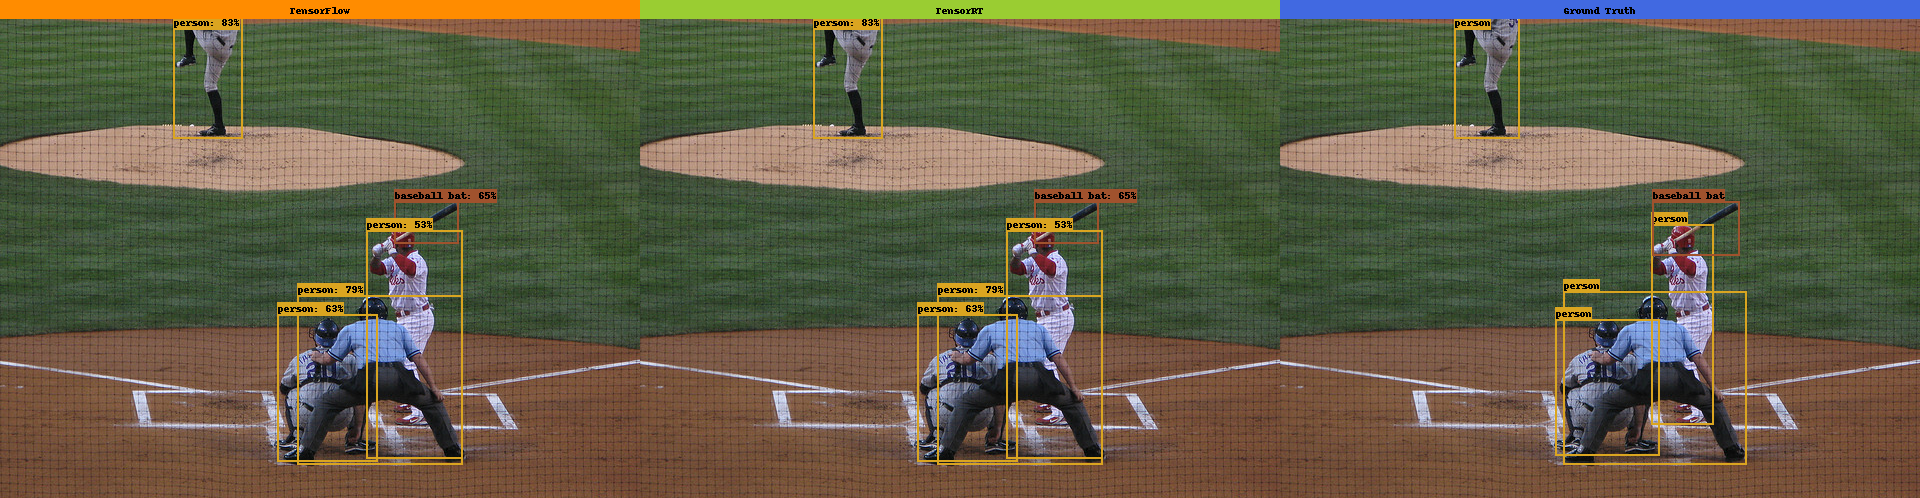

The inference on validation image from [COCO dataset](http://images.cocodataset.org/zips/val2017.zip) using TensorRT engine of EfficientDet shows detection of people and baseball bat 

The predictions on left are by TensorFlow saved model, in the center are TensorRT predictions and the ones on the right are ground truth. As we can see, the accuracy of EfficientDet TensorRT engine predictions remain same as the original TensorRT model. 

The TensorRT engine built with this process can also be deployed at scale with either [Triton Inference Server](https://developer.nvidia.com/nvidia-triton-inference-server) or [DeepStream SDK](https://developer.nvidia.com/deepstream-sdk).

## Validation on entire dataset

Given a validation dataset (such as [COCO val2017 data](http://images.cocodataset.org/zips/val2017.zip)) and ground truth annotations (such as [COCO instances_val2017.json](http://images.cocodataset.org/annotations/annotations_trainval2017.zip)), you can get the mAP metrics for the built TensorRT engine. This will use the mAP metrics calculation script from the AutoML EfficientDet repository on `https://github.com/google/automl`.

```
python eval_coco.py \
    --engine /path/to/engine.trt \
    --input /path/to/coco/val2017 \
    --annotations /path/to/coco/annotations/instances_val2017.json \
    --automl_path /path/to/automl
```

Where the `--automl_path` argument points to the root of the AutoML repository.

**NOTE:** mAP metrics are highly sensitive to NMS threshold. Using a high threshold will obviously reduce the mAP value. Ideally, this should run with a threshold of 0.00 or 0.01, but such a low threshold will impact the runtime performance of the EfficientNMS plugin. So you may need to build separate TensorRT engines for different purposes, one with a low threshold (like 0.01) dedicated for validation, and one with your application specific threshold (like 0.4) for deployment inference to minimimze latency. This is why we keep the NMS threshold as a configurable parameter in the TensorRT conversion script.

